In [9]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 9.9 MB/s eta 0:00:00:00:010:01m
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 8.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 8.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 6.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [99]:
#Import Libraries

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [101]:
#import ZipFile

import zipfile
import os

with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("extracted_data")

In [103]:
#Load & Preprocess MRI Images

import os

print("Train folders:", os.listdir("extracted_data/Combined Dataset/train"))
print("Test folders:", os.listdir("extracted_data/Combined Dataset/test"))

label_map = {
    'No Impairment': 0,
    'Very Mild Impairment': 1,
    'Mild Impairment': 2,
    'Moderate Impairment': 3
}
print("Label map:" ,label_map)

Train folders: ['No Impairment', 'Moderate Impairment', 'Very Mild Impairment', 'Mild Impairment']
Test folders: ['No Impairment', 'Moderate Impairment', 'Very Mild Impairment', 'Mild Impairment']
Label map: {'No Impairment': 0, 'Very Mild Impairment': 1, 'Mild Impairment': 2, 'Moderate Impairment': 3}


In [105]:

#Image Loader function

import os
import cv2
import numpy as np

def load_images_from_directory(base_dir, label_map, img_size=(128, 128)):
    print(f"Function called with base_dir: {base_dir}")
    images = []
    labels = []

    for label_name, label in label_map.items():
        class_path = os.path.join(base_dir, label_name)
        print(f"Checking folder: {class_path}")

        if not os.path.exists(class_path):
            print(f"WARNING: Folder does not exist: {class_path}")
            continue

        files = os.listdir(class_path)
        if not files:
            print(f"WARNING: No files in folder: {class_path}")
            continue

        for img_file in files:
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"WARNING: Could not read image: {img_path}")
                        continue
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"ERROR loading image {img_path}: {e}")

    if not images:
        print("ERROR: No images were loaded. Please check the directory and file formats.")
    
    return np.array(images), np.array(labels)

train_dir = "extracted_data/Combined Dataset/train"
test_dir = "extracted_data/Combined Dataset/test"

X_train, y_train = load_images_from_directory(train_dir, label_map)
X_test, y_test = load_images_from_directory(test_dir, label_map)

# Normalize & expand dims
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

Function called with base_dir: extracted_data/Combined Dataset/train
Checking folder: extracted_data/Combined Dataset/train/No Impairment
Checking folder: extracted_data/Combined Dataset/train/Very Mild Impairment
Checking folder: extracted_data/Combined Dataset/train/Mild Impairment
Checking folder: extracted_data/Combined Dataset/train/Moderate Impairment
Function called with base_dir: extracted_data/Combined Dataset/test
Checking folder: extracted_data/Combined Dataset/test/No Impairment
Checking folder: extracted_data/Combined Dataset/test/Very Mild Impairment
Checking folder: extracted_data/Combined Dataset/test/Mild Impairment
Checking folder: extracted_data/Combined Dataset/test/Moderate Impairment


In [107]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4-class classification
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Model defined and compiled successfully.")

Model defined and compiled successfully.


In [109]:
from tensorflow.keras.utils import to_categorical

# Number of classes
num_classes = 4

# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [111]:
#Train the model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, y_train_cat, batch_size=32),
                    validation_data=(X_test, y_test_cat),
                    epochs=15)

Epoch 1/15


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.2591 - loss: 4.3818 - val_accuracy: 0.1423 - val_loss: 1.4155
Epoch 2/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - accuracy: 0.2414 - loss: 1.3863 - val_accuracy: 0.3886 - val_loss: 1.2745
Epoch 3/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.2918 - loss: 1.3552 - val_accuracy: 0.0094 - val_loss: 1.3988
Epoch 4/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.2527 - loss: 1.3865 - val_accuracy: 0.1400 - val_loss: 1.3905
Epoch 5/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.2406 - loss: 1.3865 - val_accuracy: 0.3503 - val_loss: 1.3877
Epoch 6/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step - accuracy: 0.2474 - loss: 1.3864 - val_accuracy: 0.1400 - val_loss: 1.3854
Epoch 7/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.2487 - loss: 1.3863 - val_accuracy: 0.1400 - val_loss: 1.3862
Epoch 8/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.2428 - loss: 1.3864 - val

In [125]:
#Evaluate the model

from sklearn.metrics import classification_report, confusion_matrix

loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict class probabilities
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_map.keys()))

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1509 - loss: 1.3847
Test Accuracy: 35.03%
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
                      precision    recall  f1-score   support

       No Impairment       0.00      0.00      0.00       640
Very Mild Impairment       0.35      1.00      0.52       448
     Mild Impairment       0.00      0.00      0.00       179
 Moderate Impairment       0.00      0.00      0.00        12

            accuracy                           0.35      1279
           macro avg       0.09      0.25      0.13      1279
        weighted avg       0.12      0.35      0.18      1279



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


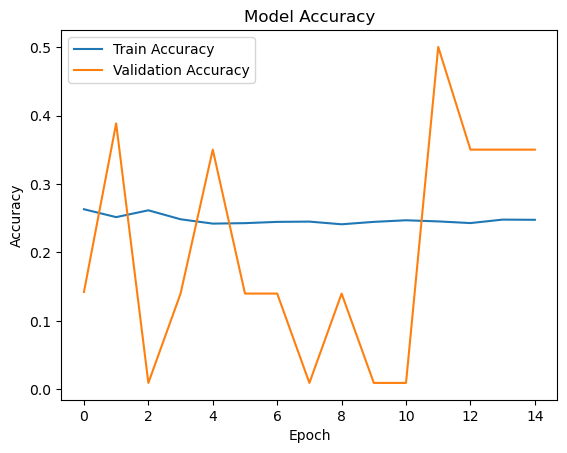

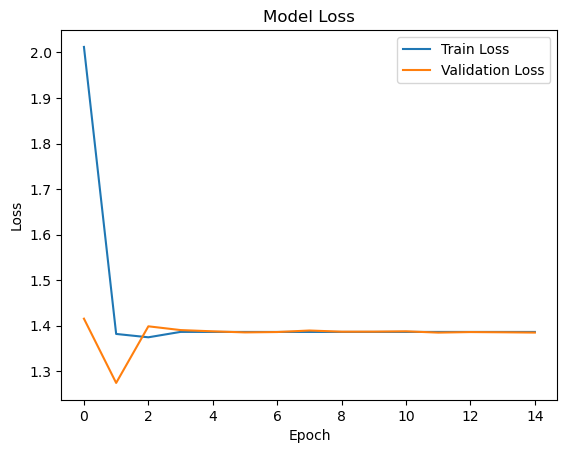

In [127]:
#Visualization

import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [129]:
#Save the trained model 

model.save('mri_classification_model.h5')
print("Model saved successfully.")

Model saved successfully.


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets